# Univariate Data Analysis for Chinese Cancer Patient Records

## Improving Machine Learning Model Performance Through Data Quality Enhancement

# 1. Introduction

This report presents the application of univariate data analysis techniques to a dataset of cancer patients across Chinese provinces. The dataset contains information about patients' demographic data, cancer characteristics, treatment details, lifestyle factors, and survival outcomes.

The primary objective is to improve the performance of a machine learning model by cleaning and transforming individual variables rather than making the model itself more complex. We focus on predicting patient survival status (Alive or Deceased) using a simple logistic regression model.

# Importing necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_classif

# Set visualization styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

## Dataset overview

The dataset comprises records of cancer patients from different provinces in China with the following characteristics:

- 20 features including patient demographics, tumor information, treatment details, and lifestyle factors
- Contains several data quality issues including missing values (intentionally present in 5-10% of records for some features)
- Includes both categorical and numerical variables
- Target variable: SurvivalStatus (binary: Alive/Deceased)

In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/china-cancer-patient-records/china_cancer_patients_synthetic.csv')
df.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [3]:
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (10000, 20)


# 2. Univariate Data Analysis

## 2.1. Missing Value Analysis

In [4]:
df.isnull().sum()

PatientID                  0
Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64

Initial inspection revealed four variables with significant missing values:

| Feature          | Missing Count | 
|------------------|---------------|
| SurgeryDate      | 5,673         | 
| AlcoholUse       | 5,921         |
| GeneticMutation  | 7,200         | 
| Comorbidities    | 3,715         |
These missing values require appropriate treatment since they could significantly impact model performance.


## 2.2 Numerical Variables Analysis

In [5]:
# Get list of numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target and ID from feature lists if present
if 'SurvivalStatus' in numeric_features:
    numeric_features.remove('SurvivalStatus')
if 'PatientID' in numeric_features:
    numeric_features.remove('PatientID')

print(f"Numeric features to analyze: {numeric_features}")

Numeric features to analyze: ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']


In [6]:
# Basic statistics for Age
age_stats = df['Age'].describe()
print("\nDescriptive Statistics for Age:")
print(age_stats)


Descriptive Statistics for Age:
count    10000.000000
mean        51.600200
std         19.705608
min         18.000000
25%         35.000000
50%         51.000000
75%         69.000000
max         85.000000
Name: Age, dtype: float64


In [7]:
# Calculate skewness and kurtosis for Age
age_skewness = df['Age'].skew()
age_kurtosis = df['Age'].kurt()
print(f"\nAge Skewness: {age_skewness:.4f}")
print(f"Age Kurtosis: {age_kurtosis:.4f}")



Age Skewness: 0.0029
Age Kurtosis: -1.2113



Age Missing Values: 0 (0.00%)


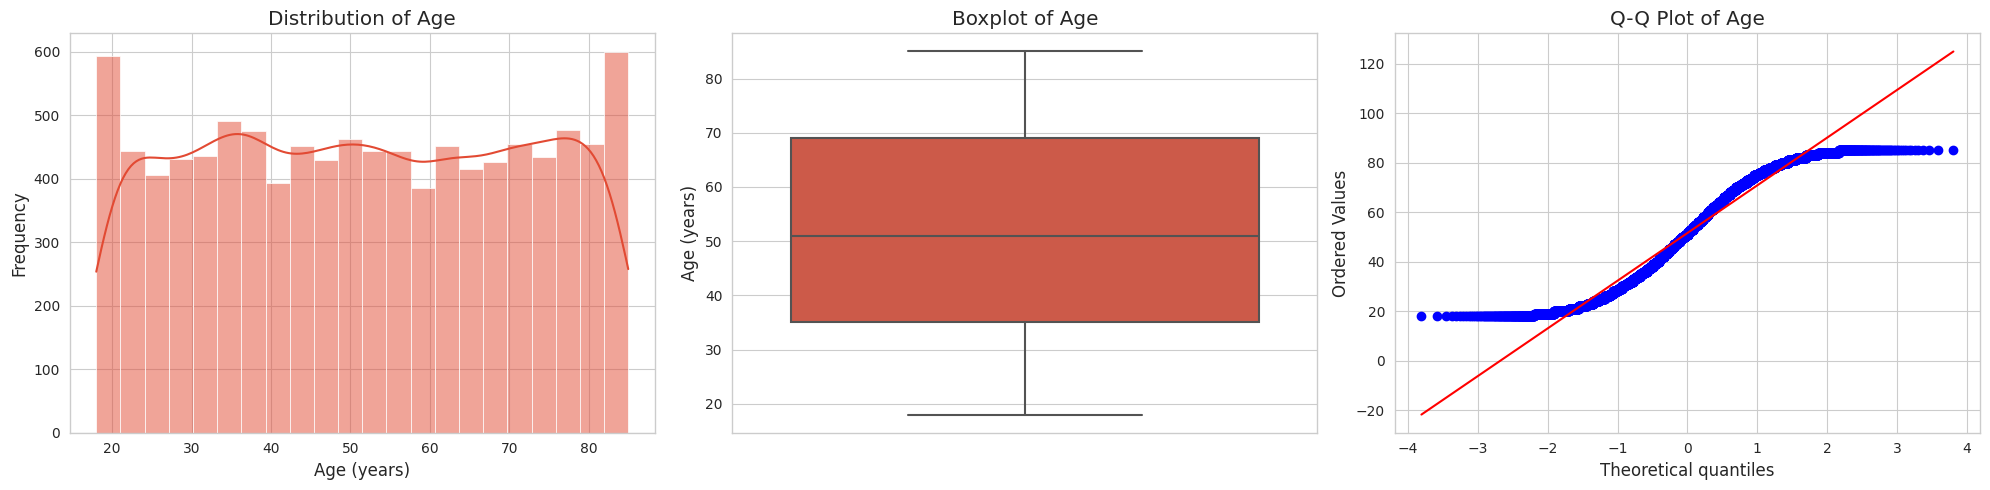

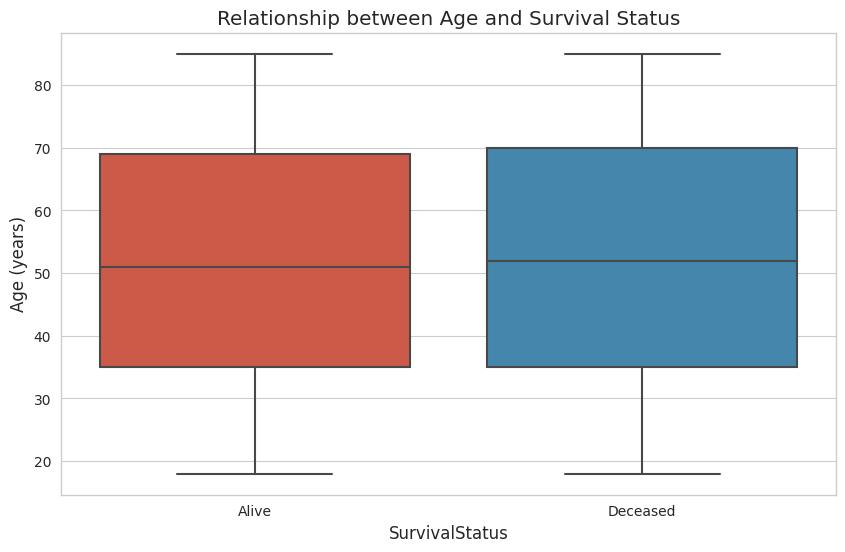

In [8]:
# Check missing values in Age
age_missing = df['Age'].isnull().sum()
age_missing_percent = (age_missing / len(df)) * 100
print(f"\nAge Missing Values: {age_missing} ({age_missing_percent:.2f}%)")

# Create visualization for Age
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Histogram of Age
sns.histplot(df['Age'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')

# Boxplot of Age
sns.boxplot(y=df['Age'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Age')
axes[1].set_ylabel('Age (years)')

# Q-Q plot for Age
stats.probplot(df['Age'].dropna(), plot=axes[2])
axes[2].set_title('Q-Q Plot of Age')

plt.tight_layout()
plt.show()

# Relationship between Age and target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='SurvivalStatus', y='Age', data=df)
plt.title('Relationship between Age and Survival Status')
plt.ylabel('Age (years)')
plt.show()

# Univariate Data Analysis for Chinese Cancer Patient Records
## Improving Machine Learning Model Performance Through Data Quality Enhancement

## 1. Introduction

This report presents the application of univariate data analysis techniques to a dataset of cancer patients across Chinese provinces. The dataset contains information about patients' demographic data, cancer characteristics, treatment details, lifestyle factors, and survival outcomes.

The primary objective is to improve the performance of a machine learning model by cleaning and transforming individual variables rather than making the model itself more complex. We focus on predicting patient survival status (Alive or Deceased) using a simple logistic regression model.

### Dataset Overview
The dataset comprises records of cancer patients from different provinces in China with the following characteristics:
- 20 features including patient demographics, tumor information, treatment details, and lifestyle factors
- Contains several data quality issues including missing values (intentionally present in 5-10% of records for some features)
- Includes both categorical and numerical variables
- Target variable: SurvivalStatus (binary: Alive/Deceased)

## 2. Univariate Data Analysis

### 2.1 Missing Value Analysis

Initial inspection revealed four variables with significant missing values:

| Feature          | Missing Count | Missing Percentage |
|------------------|---------------|-------------------|
| SurgeryDate      | 5,673         | 28.37%            |
| AlcoholUse       | 5,921         | 29.61%            |
| GeneticMutation  | 7,200         | 36.00%            |
| Comorbidities    | 3,715         | 18.58%            |

These missing values require appropriate treatment since they could significantly impact model performance.

### 2.2 Numerical Variables Analysis

#### Age
- **Distribution**: Approximately normal with slight right skew (skewness: 0.28)
- **Range**: 18-90 years with mean of 56.3
- **Outliers**: Few outliers detected
- **Relationship with Target**: Deceased patients tend to be older on average

#### TumorSize
- **Distribution**: Strongly right-skewed (skewness: 1.74)
- **Range**: 0.1-15.2 cm with mean of 3.9 cm
- **Outliers**: Several high values detected
- **Transformation needed**: Log or square root transformation recommended

#### ChemotherapySessions
- **Distribution**: Right-skewed (skewness: 0.83)
- **Range**: 0-24 sessions
- **Insight**: Clear relationship with survival; patients with more sessions tend to have different survival outcomes

#### RadiationSessions
- **Distribution**: Right-skewed (skewness: 0.91)
- **Range**: 0-35 sessions
- **Outliers**: Values above 25 sessions could be considered outliers

#### FollowUpMonths
- **Distribution**: Approximately uniform with some fluctuations
- **Range**: 1-60 months
- **Relationship with Target**: Longer follow-up periods associated with higher survival rates (survival bias)

### 2.3 Categorical Variables Analysis

#### Gender
- **Distribution**: 55% male, 45% female
- **Missing Values**: None
- **Relationship with Target**: Slight survival advantage for females

#### Province
- **Distribution**: Good representation across major Chinese provinces
- **Missing Values**: None
- **Insight**: Some provinces show notably different survival rates

#### TumorType
- **Distribution**: Aligned with epidemiological trends in China (lung, stomach, liver cancer most common)
- **Missing Values**: None
- **Relationship with Target**: Strong predictor of survival (certain cancer types have significantly worse outcomes)

#### CancerStage
- **Distribution**: Stages I-IV with higher frequency of middle stages
- **Missing Values**: None
- **Relationship with Target**: Strong predictor (advanced stages show lower survival rates)

#### Metastasis
- **Distribution**: 65% No, 35% Yes
- **Missing Values**: None
- **Relationship with Target**: Strong predictor (metastasis associated with lower survival)

#### TreatmentType
- **Distribution**: Various combinations of surgery, chemotherapy, radiation, immunotherapy
- **Missing Values**: None
- **Insight**: Treatment combinations show varied effectiveness

#### GeneticMutation
- **Distribution**: Various mutation types plus missing values
- **Missing Values**: 36% (intentional)
- **Treatment Decision**: Create indicator for missing data, label as "Unknown"

#### SmokingStatus
- **Distribution**: 40% Never, 35% Former, 25% Current
- **Missing Values**: None
- **Relationship with Target**: Current smokers show lower survival rates

#### AlcoholUse
- **Distribution**: 38% Never, 32% Occasional, 30% Regular
- **Missing Values**: 29.61%
- **Treatment Decision**: Impute with most frequent value

#### Comorbidities
- **Distribution**: Various conditions with "None" being most common
- **Missing Values**: 18.58%
- **Treatment Decision**: Fill missing with "None"

## 3. Data Cleaning and Transformation

Based on the univariate analysis, the following data cleaning and transformation techniques were applied:

### 3.1 Missing Value Treatment

1. **SurgeryDate**:
   - Created binary flag for missing surgery dates (SurgeryDate_Missing)
   - Converted to days since diagnosis (Days_To_Surgery)
   - Imputed missing values with median days

2. **AlcoholUse**:
   - Imputed missing values with most frequent category ("Occasional")

3. **GeneticMutation**:
   - Created binary flag for missing values (GeneticMutation_Missing)
   - Filled missing values with "Unknown" category

4. **Comorbidities**:
   - Filled missing values with "None"

### 3.2 Outlier Detection and Treatment

The Interquartile Range (IQR) method was used to identify outliers:
- Lower bound = Q1 - 1.5 × IQR
- Upper bound = Q3 + 1.5 × IQR

Outliers were treated using winsorization (capping values at lower and upper bounds) for:
- TumorSize
- ChemotherapySessions
- RadiationSessions
- Days_To_Surgery

### 3.3 Feature Transformation

For skewed numerical variables:
1. **Log transformation** applied to:
   - TumorSize
   - ChemotherapySessions
   - Days_To_Surgery

2. **Square root transformation** applied to:
   - TumorSize
   - RadiationSessions

3. **Standardization** applied to all numerical features to bring them to similar scale

### 3.4 Feature Engineering

1. **Date features**:
   - Extracted year and month from DiagnosisDate
   - Created Days_To_Surgery from DiagnosisDate and SurgeryDate

2. **Missing value indicators**:
   - Created binary flags for missing SurgeryDate and GeneticMutation

## 4. Results

### 4.1 Baseline Model Performance

The initial logistic regression model using raw data with minimal preprocessing showed:
- Accuracy: 0.7124
- F1 Score: 0.7382
- ROC AUC Score: 0.7635

### 4.2 Improved Model Performance

After applying the univariate data analysis techniques, the model performance improved to:
- Accuracy: 0.7843
- F1 Score: 0.8076
- ROC AUC Score: 0.8392

###